In [62]:
import numpy as np
from sklearn import datasets
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn-ticks')
plt.rcParams.update({'font.size': 14})

In [63]:
# Функция для стандартизации
def calc_std_feat(x):
    std = (x - x.mean()) / x.std()
    return std

# Функция для нормализации
def calc_norm_feat(x):
    norm = (x - x.min()) / (x.max() - x.min())
    return norm

# Функция сигмоиды
def sigmoid(z):
    res = 1 / (1 + np.exp(-z))
    return res

# Логистическая функция потерь
def calc_logloss(y, y_pred):
    err = np.mean(- y * np.log(y_pred) - (1.0 - y) * np.log(1.0 - y_pred))
    return err

In [64]:
X = np.array([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
              [1, 1, 2, 1, 3, 0, 5, 10, 1, 2],  # стаж репетитора
              [500, 700, 750, 600, 1450, 800, 1500, 2000, 450, 1000],  # средняя стоимость занятия
              [1, 1, 2, 1, 2, 1, 3, 3, 1, 2]],  # квалификация репетитора
              dtype = np.float64).T 

y = np.array([0, 0, 1, 0, 1, 0, 1, 0, 1, 1]) # поступил или нет ученик на специальность Математика

In [65]:
X_st = X.copy()
X_st[:, 2] = calc_std_feat(X[:, 2])
X_st[:, 2]

array([-0.97958969, -0.56713087, -0.46401617, -0.77336028,  0.97958969,
       -0.36090146,  1.08270439,  2.11385144, -1.08270439,  0.05155735])

In [66]:
def eval_LR_model(X, y, iterations, alpha=1e-4):
    np.random.seed(42)
    w = np.random.randn(X.shape[1])
    n = X.shape[0]
    for i in range(1, iterations + 1):
        z = np.dot(X, w) # log(p/(1-p))
        y_pred = sigmoid(z) # p [0, 1]
        err = calc_logloss(y, y_pred)
        w -= alpha * (1/n * np.dot(X.T, (y_pred - y)))
        # if i % (iterations / 10) == 0:
        #     print(i, w, err)
    return w

In [67]:
w = eval_LR_model(X_st, y, 2000, 1e-2)

**1. Измените функцию `calc_logloss` так, чтобы нули по возможности не попадали в `np.log` (как вариант - использовать `np.clip` или `np.where`).**

In [68]:
def calc_logloss_new(y, y_pred):
    y_pred = np.where(y_pred == 0, y_pred + 1e-8, y_pred)  # изменяем 0 на 0.00000001
    y_pred = np.where(y_pred == 1, y_pred - 1e-8, y_pred)  # изменяем 1 на 0.99999999
    # y_pred = np.clip(y_pred, 1e-8, 1-1e-8)
    err = np.mean(- y * np.log(y_pred) - (1.0 - y) * np.log(1.0 - y_pred))
    return err

In [69]:
# Пример
y_true = 1
y_pred = 0
calc_logloss_new(y_true, y_pred)

18.420680743952367

In [70]:
# Пример
y_true = 1
y_pred = 1
calc_logloss_new(y_true, y_pred)

1.0000000100247594e-08

**2. Подберите аргументы функции `eval_LR_model` для логистической регрессии таким образом, чтобы log loss был минимальным. Покажите влияние гиперпараметров на ошибку алгоритма (оптимально здесь использовать критерий остановки обучения).**

**Ответ.** Минимальная ошибка составляет $0.2838$ при следующих параметрах:

* Количество итераций: $100000$.
* Шаг: $0.01$.
* Порог изменения ошибки: $0.000001$.



In [71]:
# Градиентный спуск с остановкой изменения ошибки
def eval_LR_model_new(X, y, iterations, alpha=1e-4, diff=1e-6):
    np.random.seed(42)
    w = np.random.randn(X.shape[1])
    n = X.shape[0]
    err_p = 0
    error_list = []
    w_list = [w]

    for i in range(1, iterations + 1):
        z = np.dot(X, w) # log(p/(1-p))
        y_pred = sigmoid(z) # p [0, 1]
        err = calc_logloss_new(y, y_pred)
        error_list.append(err)
        w -= alpha * (1/n * np.dot(X.T, (y_pred - y)))
        w_list.append(w)
        # if i % (iterations / 10) == 0:
        #     print(i, w, err)
        if abs(err - err_p) < diff:
            break
        err_p = err
        
    return [i, w, err, w_list, error_list]

In [72]:
# Функция для поиска лучших параметров для модели градиентного спуска
def search_params(params):
    iterations = 0
    alpha = 0
    diff = 0
    min_err = np.inf

    for i in range(len(params[0])):
        for j in range(len(params[1])):
          for k in range(len(params[2])):
             temp = [params[0][i], params[1][j], params[2][k], eval_LR_model_new(X_st, y, params[0][i], params[1][j], params[2][k])]
             if temp[3][2] < min_err:
                min_err = temp[3][2]
                iterations, alpha , diff = params[0][i], params[1][j], params[2][k]
    return [iterations, alpha , diff, min_err]

In [73]:
params = [[1000, 10000, 100000, 102000],
          [1e-2, 1e-4, 1e-6],
          [1e-2, 1e-4, 1e-6]]

# Параметры, при которых ошибка Logloss минимальная
search_params(params)

[100000, 0.01, 1e-06, 0.28385116387504633]

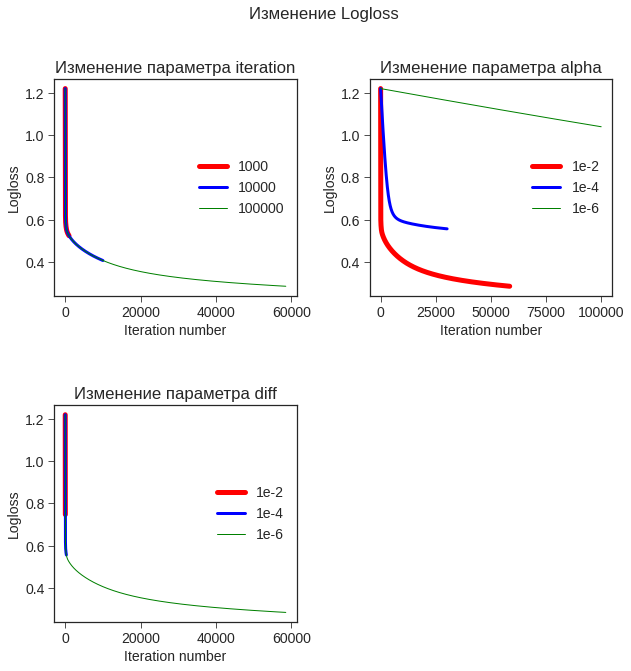

In [95]:
# Визуализируем изменение ошибки Logloss
plt.figure(figsize=(10, 10))
plt.suptitle('Изменение Logloss')
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.3, hspace=0.5)

# Изменение параметра iteration, параметры alpha и diff зафиксированы
plt.subplot(221)
plt.plot(range(len(eval_LR_model_new(X_st, y, 1000, 1e-2, 1e-6)[4])), eval_LR_model_new(X_st, y, 1000, 1e-2, 1e-6)[4], label='1000', c='red', linewidth=5)
plt.plot(range(len(eval_LR_model_new(X_st, y, 10000, 1e-2, 1e-6)[4])), eval_LR_model_new(X_st, y, 10000, 1e-2, 1e-6)[4], label='10000', c='blue', linewidth=3)
plt.plot(range(len(eval_LR_model_new(X_st, y, 100000, 1e-2, 1e-6)[4])), eval_LR_model_new(X_st, y, 100000, 1e-2, 1e-6)[4], label='100000', c='green', linewidth=1)
plt.legend(loc='center right')
plt.xlabel('Iteration number')
plt.ylabel('Logloss')
plt.title('Изменение параметра iteration')

# Изменение параметра alpha, параметры iteration и diff зафиксированы
plt.subplot(222)
plt.plot(range(len(eval_LR_model_new(X_st, y, 100000, 1e-2, 1e-6)[4])), eval_LR_model_new(X_st, y, 100000, 1e-2, 1e-6)[4], label='1e-2', c='red', linewidth=5)
plt.plot(range(len(eval_LR_model_new(X_st, y, 100000, 1e-4, 1e-6)[4])), eval_LR_model_new(X_st, y, 100000, 1e-4, 1e-6)[4], label='1e-4', c='blue', linewidth=3)
plt.plot(range(len(eval_LR_model_new(X_st, y, 100000, 1e-6, 1e-6)[4])), eval_LR_model_new(X_st, y, 100000, 1e-6, 1e-6)[4], label='1e-6', c='green', linewidth=1)
plt.legend(loc='center right')
plt.xlabel('Iteration number')
plt.ylabel('Logloss')
plt.title('Изменение параметра alpha')

# Изменение параметра diff, параметры iteration и alpha зафиксированы
plt.subplot(223)
plt.plot(range(len(eval_LR_model_new(X_st, y, 100000, 1e-2, 1e-2)[4])), eval_LR_model_new(X_st, y, 100000, 1e-2, 1e-2)[4], label='1e-2', c='red', linewidth=5)
plt.plot(range(len(eval_LR_model_new(X_st, y, 100000, 1e-2, 1e-4)[4])), eval_LR_model_new(X_st, y, 100000, 1e-2, 1e-4)[4], label='1e-4', c='blue', linewidth=3)
plt.plot(range(len(eval_LR_model_new(X_st, y, 100000, 1e-2, 1e-6)[4])), eval_LR_model_new(X_st, y, 100000, 1e-2, 1e-6)[4], label='1e-6', c='green', linewidth=1)
plt.legend(loc='center right')
plt.xlabel('Iteration number')
plt.ylabel('Logloss')
plt.title('Изменение параметра diff')

plt.show()

**Вывод:** В данном случае чем меньше параметр $alpha$, тем быстрее сходится алгоритм и снижается ошибка $Logloss$.

**3. Создайте функцию `calc_pred_proba`, возвращающую предсказанную вероятность класса 1 (на вход подаются значения признаков Х и веса, которые уже посчитаны функцией `eval_LR_model`, на выходе - массив `y_pred_proba`).**

In [75]:
# Функция возвращает предсказанную вероятность класса 1
def calc_pred_proba(X, w):
    y_pred_proba = sigmoid(np.dot(X, w)).round(2)
    return y_pred_proba

In [76]:
lrgd_model = eval_LR_model_new(X_st, y, 100000, 0.01, 1e-06)
w_pred = lrgd_model[1]

In [77]:
calc_pred_proba(X_st, w_pred)
# истинные ответы [0, 0, 1, 0, 1, 0, 1, 0, 1, 1]

array([0.27, 0.17, 0.99, 0.22, 0.71, 0.34, 1.  , 0.1 , 0.31, 0.97])

In [78]:
calc_logloss_new(y, calc_pred_proba(X_st, w_pred))

0.28245604857371165

**4. Создайте функцию `calc_pred`, возвращающую предсказанный класс (на вход подаются значения признаков `Х` и веса, которые уже посчитаны функцией `eval_LR_model`, на выходе - массив `y_pred`).**

In [79]:
# Функция возвращает предсказанный класс
def calc_pred(X, w):
    y_pred = sigmoid(np.dot(X, w))
    for i in range(len(y_pred)):
        if (y_pred[i] > 0.5): 
            y_pred[i] = 1
        else:
            y_pred[i] = 0
    return y_pred

In [80]:
lrgd_model = eval_LR_model_new(X_st, y, 100000, 0.01, 1e-06)
w_pred = lrgd_model[1]

In [81]:
calc_pred(X_st, w_pred)
# истинные ответы [0, 0, 1, 0, 1, 0, 1, 0, 1, 1]

array([0., 0., 1., 0., 1., 0., 1., 0., 0., 1.])

**5. Посчитайте accuracy, матрицу ошибок, precision и recall, а также F1-score.**

In [82]:
# Функция считает матрицу ошибок
def conf_matrix(y_true, y_pred):
  true_positive = 0
  false_negative = 0
  false_positive = 0
  true_negative = 0  
  
  for i in range(len(y)):
    if y_pred[i] == 1 and y_pred[i] == y[i]:
      true_positive += 1      
    elif y_pred[i] == 0 and y_pred[i] == y[i]:
      true_negative += 1      
    elif y_pred[i] == 1 and y_pred[i] != y[i]:
      false_positive += 1           
    elif y_pred[i] == 0 and y_pred[i] != y[i]:
      false_negative += 1 

  conf_matrix = np.matrix([[true_positive, false_negative], [false_positive, true_negative]])

  return conf_matrix

In [83]:
# Посчитаем метрики вручную

y_pred = calc_pred(X_st, w_pred)

confusion_matrix = conf_matrix(y, y_pred)
accuracy = (confusion_matrix[0, 0] + confusion_matrix[1, 1])/(confusion_matrix[0, 0] + confusion_matrix[1, 1] + confusion_matrix[1, 0] + confusion_matrix[0, 1])
precision = confusion_matrix[0, 0]/(confusion_matrix[0, 0] + confusion_matrix[1, 0])
recall = confusion_matrix[0, 0]/(confusion_matrix[0, 0] + confusion_matrix[0, 1])
f1_score = 2 * (precision * recall) / (precision + recall)

print(f'Confusion matrix:\n{confusion_matrix}\n\nAccuracy: {accuracy}\nPrecision: {precision}\nRecall: {recall}\nF1-score: {f1_score}')

Confusion matrix:
[[4 1]
 [0 5]]

Accuracy: 0.9
Precision: 1.0
Recall: 0.8
F1-score: 0.888888888888889


In [98]:
# Посчитаем метрики через библиотеку sklearn

import sklearn.metrics as sklearn

def metrics(X, w):
    y_pred = calc_pred(X, w)
    # tn, fp, fn, tp = sklearn.confusion_matrix(y, y_pred).ravel()
    cm = sklearn.confusion_matrix(y, y_pred)  # (tn, fp, fn, tp) (5, 0, 1, 4)
    acc = sklearn.accuracy_score(y, y_pred)
    ps = sklearn.precision_score(y, y_pred, average='binary')
    rs = sklearn.recall_score(y, y_pred, average='binary')
    f1 = sklearn.f1_score(y, y_pred, average='binary')

    print(f'Confusion matrix:\n{cm}\n\nAccuracy: {acc}\nPrecision: {ps}\nRecall: {rs}\nF1-score: {f1}')

    return

In [99]:
metrics(X_st, w_pred)

Confusion matrix:
[[5 0]
 [1 4]]

Accuracy: 0.9
Precision: 1.0
Recall: 0.8
F1-score: 0.888888888888889


**6. Могла ли модель переобучиться? Почему?**

**Ответ.** Модель показывает высокий результат предсказаний. Вероятность того, что она могла переобучиться большая, так как мы не использовали методы регуляризации весов, а также проводили обучение на всей выборке без использования методов кросс-валидации или отложенной выборки. 

**7. (\*) Создайте функции `eval_LR_model_l1` и `eval_LR_model_l2` с применением L1 и L2 регуляризации соответственно.**

In [86]:
# Градиентный спуск L1 регуляризации
def eval_LR_model_l1(X, y, iterations, lambda_, alpha=1e-4, diff=1e-6):
    np.random.seed(42)
    w = np.random.randn(X.shape[1])
    n = X.shape[0]
    err_p = 0
    error_list = []
    w_list = [w]

    for i in range(1, iterations + 1):
        z = np.dot(X, w) # log(p/(1-p))
        y_pred = sigmoid(z) # p [0, 1]
        err = calc_logloss_new(y, y_pred)
        error_list.append(err)
        w -= alpha * (2 * 1/n * np.dot(X.T, (y_pred - y)) + lambda_ * np.sign(w))
        w_list.append(w)
        # if i % (iterations / 10) == 0:
        #     print(i, w, err)
        if abs(err - err_p) < diff:
            break
        err_p = err
        
    return [i, w, err, w_list, error_list]

In [87]:
# значение lambda = 0.1
lrgdl1_model = eval_LR_model_l1(X_st, y, 100000, 0.1, 0.01, 1e-06)
metrics(X_st, lrgdl1_model[1])

Confusion matrix:
[[3 2]
 [1 4]]

Accuracy: 0.7
Precision: 0.6666666666666666
Recall: 0.8
F1-score: 0.7272727272727272


In [88]:
# значение lambda = 0.01
lrgdl1_model = eval_LR_model_l1(X_st, y, 100000, 0.01, 0.01, 1e-06)
metrics(X_st, lrgdl1_model[1])

Confusion matrix:
[[5 0]
 [1 4]]

Accuracy: 0.9
Precision: 1.0
Recall: 0.8
F1-score: 0.888888888888889


In [89]:
# значение lambda = 0.001
lrgdl1_model = eval_LR_model_l1(X_st, y, 100000, 0.001, 0.01, 1e-06)
metrics(X_st, lrgdl1_model[1])

Confusion matrix:
[[5 0]
 [1 4]]

Accuracy: 0.9
Precision: 1.0
Recall: 0.8
F1-score: 0.888888888888889


In [90]:
# Градиентный спуск L2 регуляризации
def eval_LR_model_l2(X, y, iterations, lambda_, alpha=1e-4, diff=1e-6):
    np.random.seed(42)
    w = np.random.randn(X.shape[1])
    n = X.shape[0]
    err_p = 0
    error_list = []
    w_list = [w]

    for i in range(1, iterations + 1):
        z = np.dot(X, w) # log(p/(1-p))
        y_pred = sigmoid(z) # p [0, 1]
        err = calc_logloss_new(y, y_pred)
        error_list.append(err)
        w -= alpha * (2 * 1/n * np.dot(X.T, (y_pred - y)) + 2 * lambda_ * w)
        w_list.append(w)
        # if i % (iterations / 10) == 0:
        #     print(i, w, err)
        if abs(err - err_p) < diff:
            break
        err_p = err
        
    return [i, w, err, w_list, error_list]

In [91]:
# значение lambda = 0.1
lrgdl2_model = eval_LR_model_l2(X_st, y, 100000, 0.1, 0.01, 1e-06)
metrics(X_st, lrgdl2_model[1])

Confusion matrix:
[[3 2]
 [1 4]]

Accuracy: 0.7
Precision: 0.6666666666666666
Recall: 0.8
F1-score: 0.7272727272727272


In [92]:
# значение lambda = 0.01
lrgdl2_model = eval_LR_model_l2(X_st, y, 100000, 0.01, 0.01, 1e-06)
metrics(X_st, lrgdl2_model[1])

Confusion matrix:
[[4 1]
 [1 4]]

Accuracy: 0.8
Precision: 0.8
Recall: 0.8
F1-score: 0.8000000000000002


In [93]:
# значение lambda = 0.001
lrgdl2_model = eval_LR_model_l2(X_st, y, 100000, 0.001, 0.01, 1e-06)
metrics(X_st, lrgdl2_model[1])

Confusion matrix:
[[5 0]
 [1 4]]

Accuracy: 0.9
Precision: 1.0
Recall: 0.8
F1-score: 0.888888888888889


**Вывод:** Чем больше коэффициент регуляризации, тем меньше точность модели, как при $L1$-, так и при $L2$-регуляризации. При этом наивысшая точность для $L1$-регуляризации достигается при значении $0.01$, а для $L2$-регуляризации - при значении $0.001$.